**Universidad de los Andes** — Facultad de Ingeniería

Autores: **Andrés Vega**, **David Méndez-Acuña**

## **Reinforced Logo**

### **Contexto**

Logo es un lenguaje de programación creado por Seymour Papert y Wallace Feurzeig en 1966. Se trata de un lenguaje concebido con fines educativos que se usa para introducir nociones básicas de algorítmica a niños en cursos tempranos de educación primaria. 

El principio de Logo se basa en una tortuga que se controla a partir de instrucciones simples de movimiento —avanzar, girar a la derecha o izquierda, retroceder, etc.—.  La tortuga deja un trazo sobre el plano sobre el que se mueve. El objetivo es entonces enseñarle al niño a programar mientras dibuja. 

### **Objetivo**

El objetivo del proyecto es enseñarle a Logo a dibujar **figuras rectangulares**. En particular, a lo largo de este documento presentaremos una solución para enseñarle a Logo a dibujar dos figuras: un cuadrado simple, y un caracol cuadrado como se ve en las imágenes a continuación.

<br>
<center>
    <img src="https://raw.githubusercontent.com/Sulfur0/turtle-drawing/master/entregable/target-figures.png" width="600">
</center>
<center>
Figura 1. Pipeline de ejecución para resolver el problema de generación automática de muestrarios de colores a partir de obras de arte.
</center>
<br>

### **Generalidades de la solución**

La solución que proponemos consta de dos etapas: **entrenamiento** y **dibujo**. Durante la fase de entrenamiento, entrenamos a Logo a partir de un sistema de recompensas que explicaremos más adelante. Como resultado de esta primera fase, obtenemos una matriz de q-valores que contiene también la política óptima que guiará a Logo durante el dibujo. Durante la fase de dibujo, Logo seguirá la política optima y dejará un trazo sobre el canvas mientras sigue esa política. 

Para esto, las posibles acciones de Logo corresponden a sus capacidades de movimiento. Originalmente, Logo soporta cuatro movimientos: forward, backward, left, right. Los dos primeros permiten avanzar y retroceder tantos pasos como se indique en el parámetro. Los dos últimos le permiten a la tortuga girar a la izquierda o a la derecha en el ángulo indicado por el parámetro. En este proyecto, **simplificaremos estos movimientos** para así limitar el movimiento de la tortuga a cuatro direcciones. Entonces, las acciones posibles serán: **up**, **down**, **left**, y **right**. Cada una de las acciones avanzará Logo hacia la dirección indicada por la acción en la cantidad de pasos indicada por el parámetro. 

### **Sistema de recompensas:** una recompensa por cada trazo



Para entrenar Logo decidimos de seguir una estrategia de una recompensa por trazo. Entonces, tendremos tantas recompensas como trazos. El entrenamiento se hará también por trazos; entrenaremos logo a seguir cada trazo por separado y la fase de dibujo integrará lo aprendido en los entrenamientos de los trazos.

Para ilustrar lo anterior, considere el ejemplo de un ciadrado. El esquema de aprendizaje por trazos se estructura de la siguiente manera.

- **Primer entrenamiento:** Le enseñamos a Logo a ir desde su punto de origen (en el vértice superior-izquierdo del canvas) al primer vértice del cuadrado. Durante este trayecto, le pedimos a Logo que mantena el lápiz arriba de manera que no deje trazo durante este primer recorrido que no hace parte de la figura. 

- **Segundo entrenamiento:** Entrenamos Logo para ir desde el primer vértice del cuadrado hacia el segundo vértice. Durante el trayecto, le pedimos a Logo que baje el lápiz de manera que deje un trazo durante su recorrido. 

- **Tercer, cuarto, y quinto entrenamiento:** Durante el resto de los entrenamientos, se sigue el mismo procedimiento que para el entrenamiento anterior. Es importante mencionar que en cada entrenamiento el punto de inicio de Logo cambia por el vértice del trazo inmediatamente anterior.

### **Fase de entrenamiento**

A continuación presentamos el código correspondiente a la fase de entrenamiento de Logo. Los tiempos de ejecución están al final de la fase de entrenamiento que se ejecutó sobre un MacBook Pro con un procesador Apple M1 y 8 GB de memoria RAM. Es importante aclarar que dada la baja complejidad de los dibujos que estamos proponiendo, la duración del entrenamiento es relativamente baja y puede medirse en segundos.

In [1]:
%run environment.ipynb
%run agent.ipynb
%run rewards.ipynb
%run logo.ipynb

import time

def train(rewards_system):
    '''
    Este método entrena a Logo a partir del sistema de recompensas que entra por parámetro. 
    El resultado de este método corresponde a un objeto de la clase 'Agente' por cada
    uno de los trazos contenidos en el sistema de recompensas. Luego del entrenamiento para cada
    trazo, este método imprime la tabla de q-valores así como una gráfica que muestra la convergencia
    de dicha tabla. 

    Entradas:
    ----------------
    - rewards_system -> array(str[][]): Sistema de recompensas que debe usarse para entrenar a Logo. 
      Se trata de un arreglo de matrices de strings. Se tienen tantas matrices como trazos en la
      figura que se quiere dibujar. Cada matriz tiene una recompensa positiva +1 (el objetivo) y un 
      punto de inicio S. No hay recompensas negativas.

    Salidas:
    ----------------
    - agents: array(Agent): Información necesaria para que Logo pueda dibujar. 
      Se trata de un arreglo de objetos de la clase Agente. Dicha clase contiene las matrices de q-valores
      que se usa para inferir la política óptima que Logo debe seguir durante el dibujo. 
    '''

    agents = []
    trace_index = 1
    start = time.time()
    for board in rewards_system:
        print(f'\nEntrenamiento para el trazo no. {trace_index} \n')
        environment = Environment(board)
        agent = Agent(environment, gamma=0.5, alpha=0.1, epsilon=0.9, episodes=2000)
        stats, duration = agent.run()
        actions, values = agent.actions_values()
        print(f'- Matriz de q-valores y política óptima. Tiempo de ejecución: {duration} segundos')
        environment.plot_action(actions, values)
        print('- Gráfica de convergencia de los q-valores a lo largo de los episodios')
        environment.plot_stats(stats)
        agents += [agent, ]
        trace_index += 1
    end = time.time()
    total_duration = end - start
    print(f'** Duracion total del entrenamiento: {total_duration} segundos')

    return agents


#### **Entrenamiento para dibujar un cuadrado**

Procedemos entonces con el primer reto: enseñarle a Logo a dibujar un cuadrado. Para eso, invocamos el método desarrollado anteriormente. El resultado de esta primera fase de entrenamiento se guarda en la variable `square_agents` que se usará más adelante para que Logo dibuje.


Entrenamiento para el trazo no. 1 

- Matriz de q-valores y política óptima. Tiempo de ejecución: 0.12035608291625977 segundos


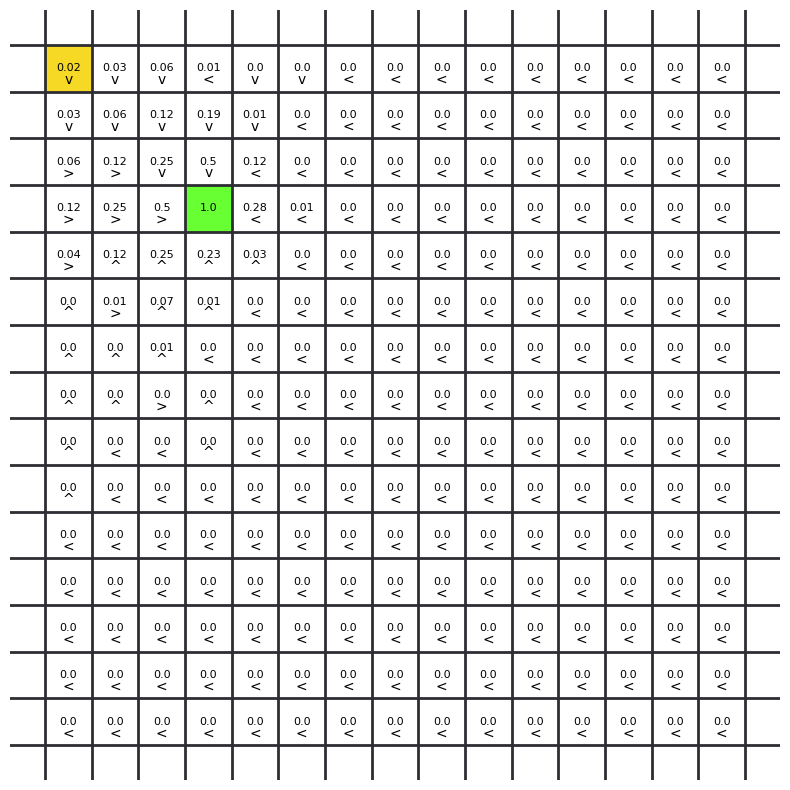

- Gráfica de convergencia de los q-valores a lo largo de los episodios


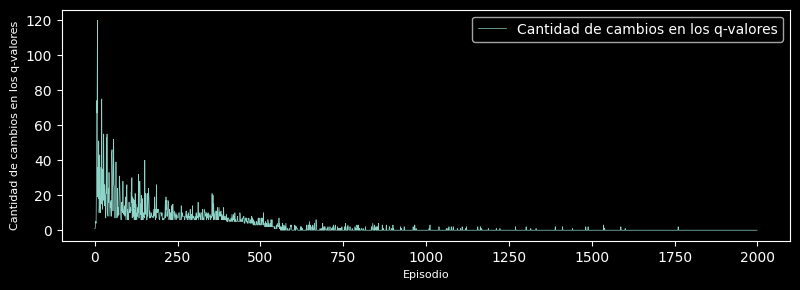


Entrenamiento para el trazo no. 2 

- Matriz de q-valores y política óptima. Tiempo de ejecución: 0.14005684852600098 segundos


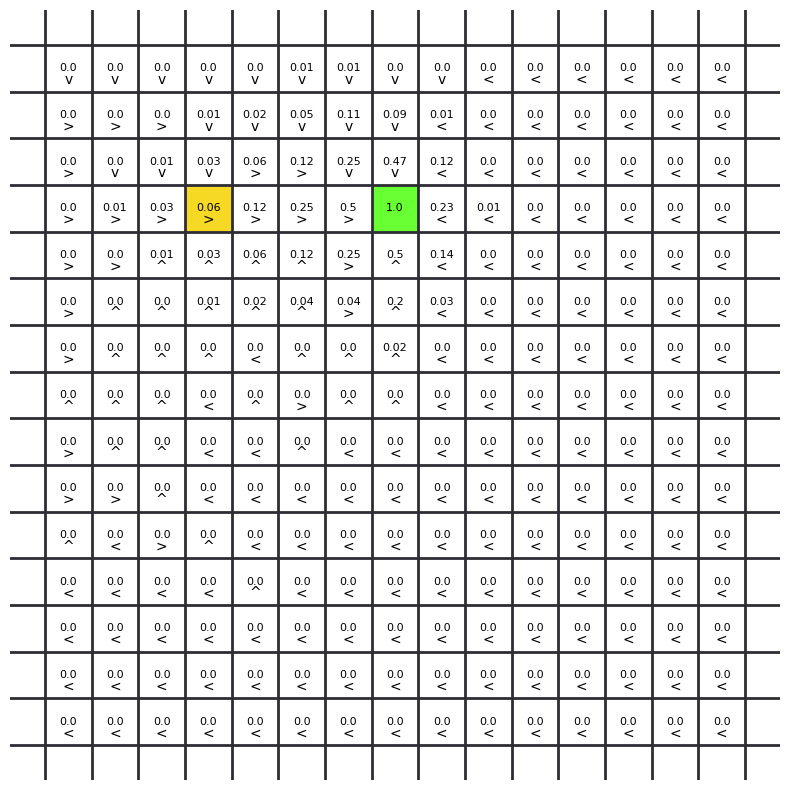

- Gráfica de convergencia de los q-valores a lo largo de los episodios


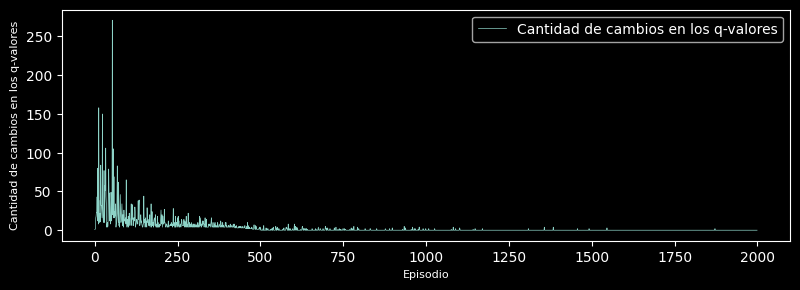


Entrenamiento para el trazo no. 3 

- Matriz de q-valores y política óptima. Tiempo de ejecución: 0.17700886726379395 segundos


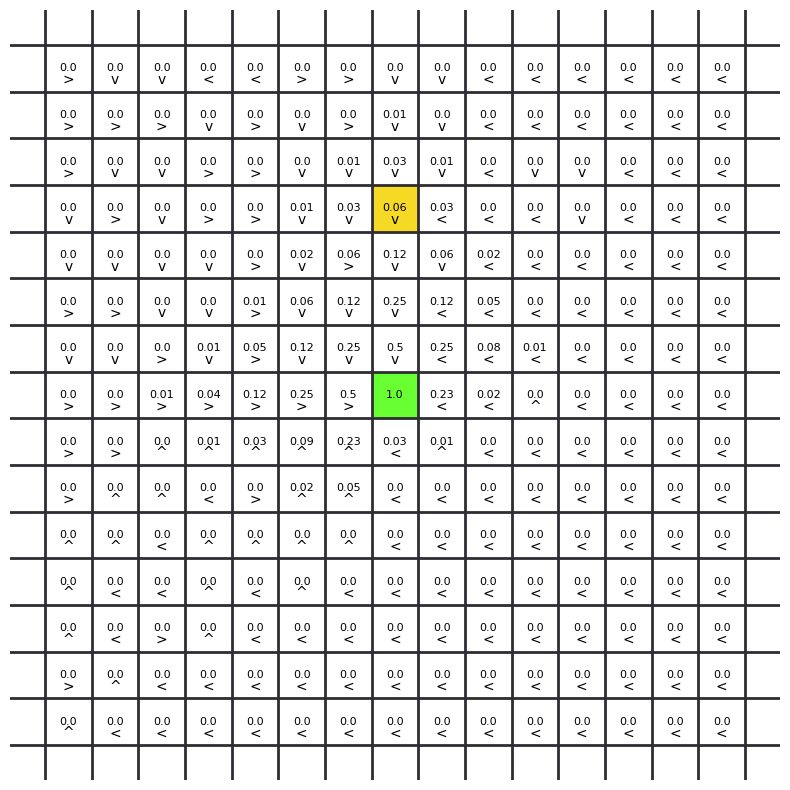

- Gráfica de convergencia de los q-valores a lo largo de los episodios


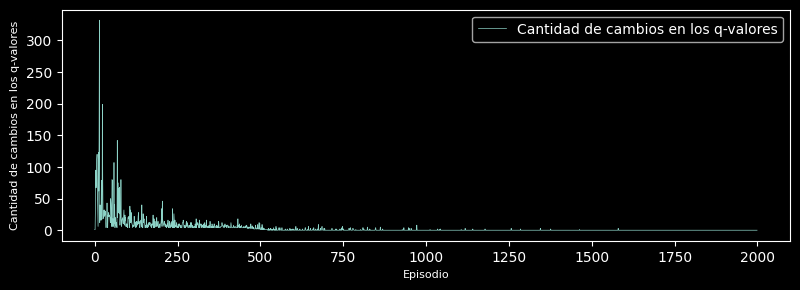


Entrenamiento para el trazo no. 4 

- Matriz de q-valores y política óptima. Tiempo de ejecución: 0.10239791870117188 segundos


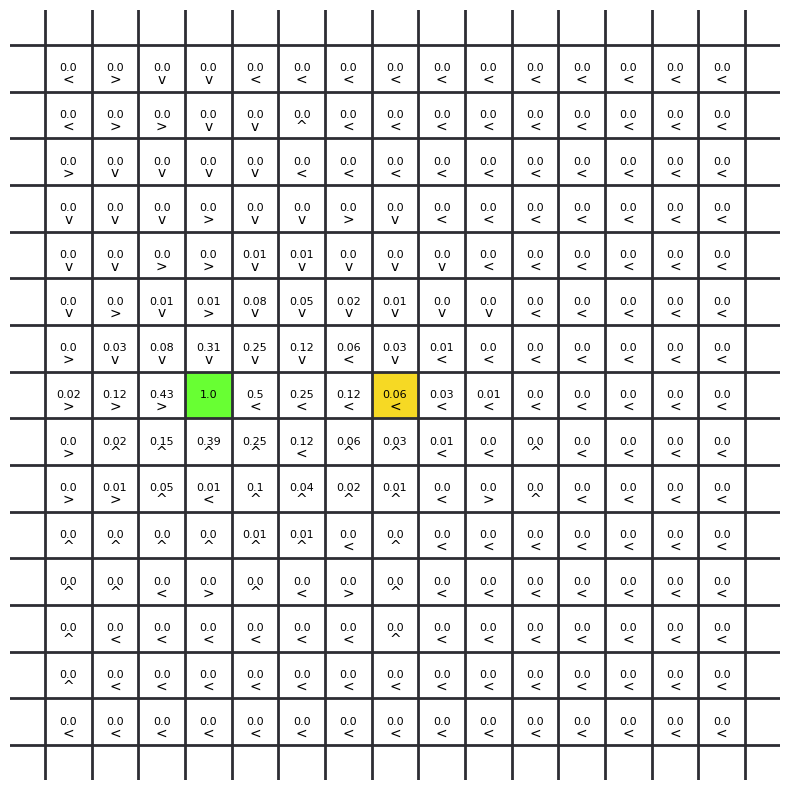

- Gráfica de convergencia de los q-valores a lo largo de los episodios


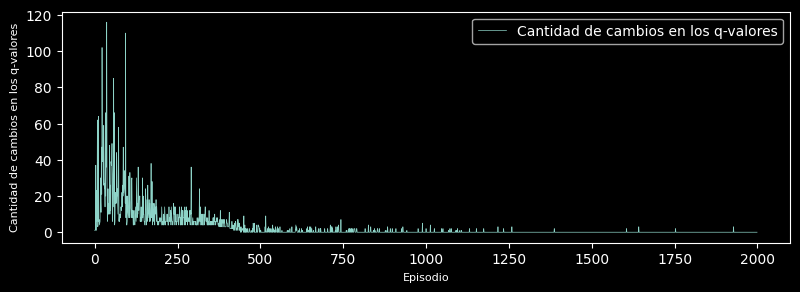


Entrenamiento para el trazo no. 5 

- Matriz de q-valores y política óptima. Tiempo de ejecución: 0.11145997047424316 segundos


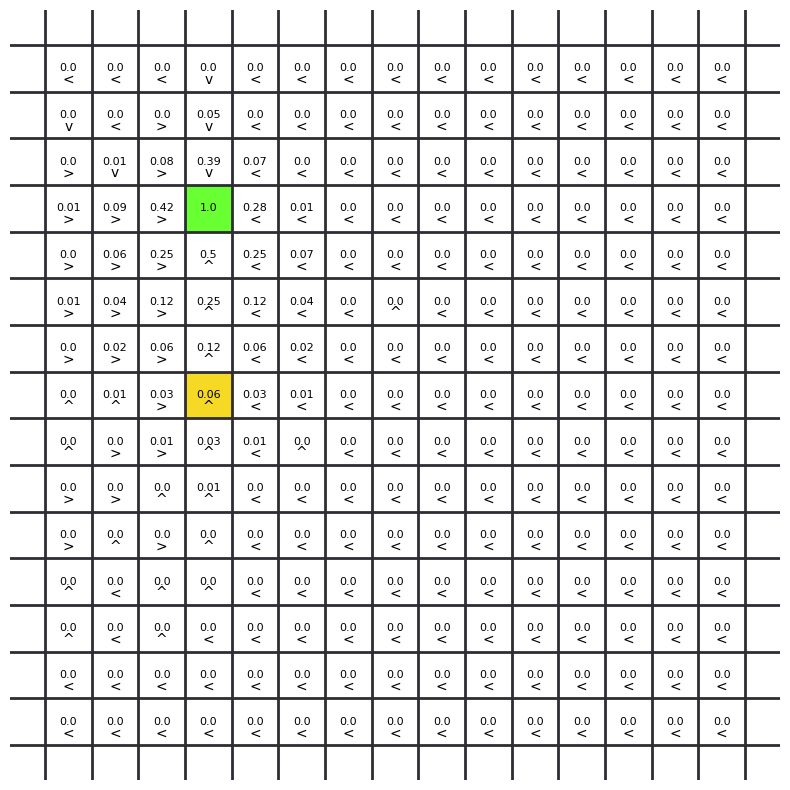

- Gráfica de convergencia de los q-valores a lo largo de los episodios


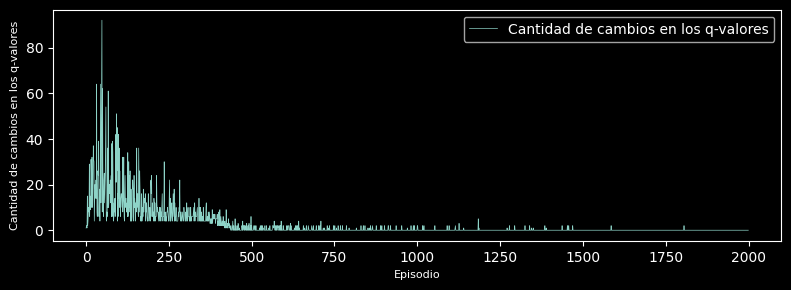

** Duracion total del entrenamiento: 2.103104829788208 segundos


In [2]:
rewards_system = Rewards().square(size=Size.L)
square_agents = train(rewards_system)

#### **Entrenamiento para dibujar un caracol cuadrado**

Procedemos entonces con el segundo reto: enseñarle a Logo a dibujar un caracol cuadrado. Para eso, invocamos el método desarrollado anteriormente. El resultado de esta primera fase de entrenamiento se guarda en la variable `snail_agents` que se usará más adelante para que Logo dibuje. Note que la cantidad de trazos para este dibujo es de 12 lo que hace su entrenamiento un poco más largo. 


Entrenamiento para el trazo no. 1 

- Matriz de q-valores y política óptima. Tiempo de ejecución: 0.04937410354614258 segundos


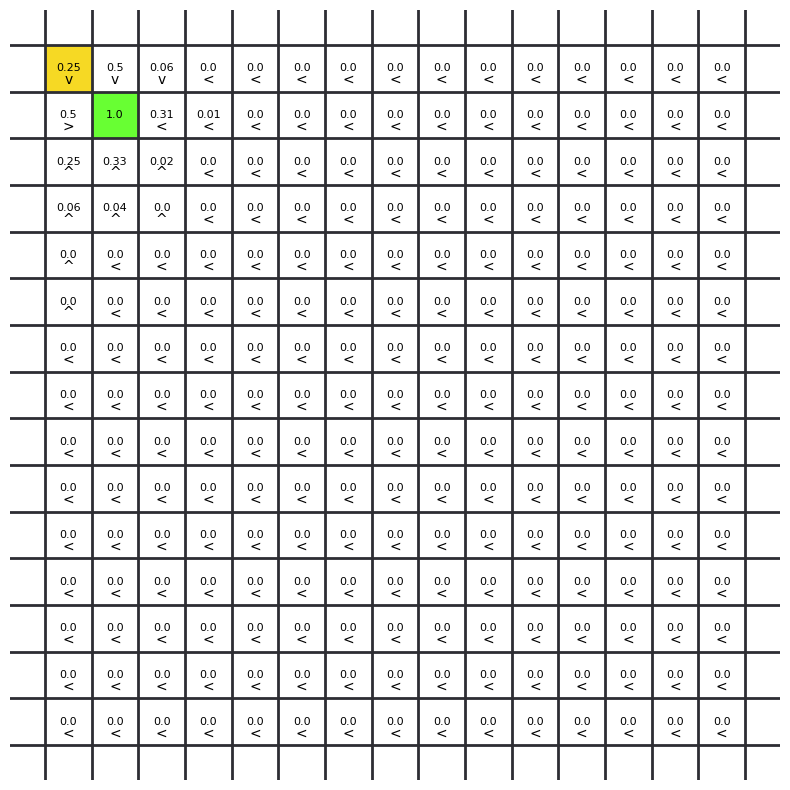

- Gráfica de convergencia de los q-valores a lo largo de los episodios


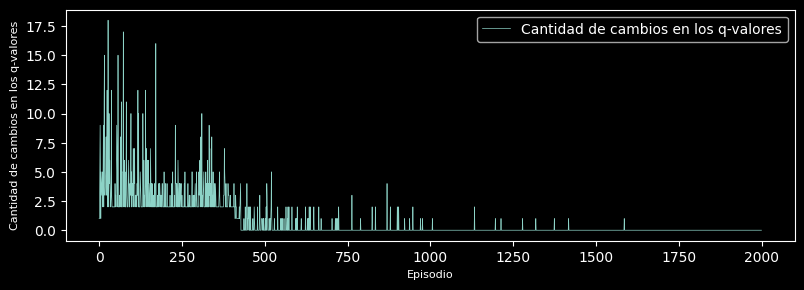


Entrenamiento para el trazo no. 2 

- Matriz de q-valores y política óptima. Tiempo de ejecución: 0.4385221004486084 segundos


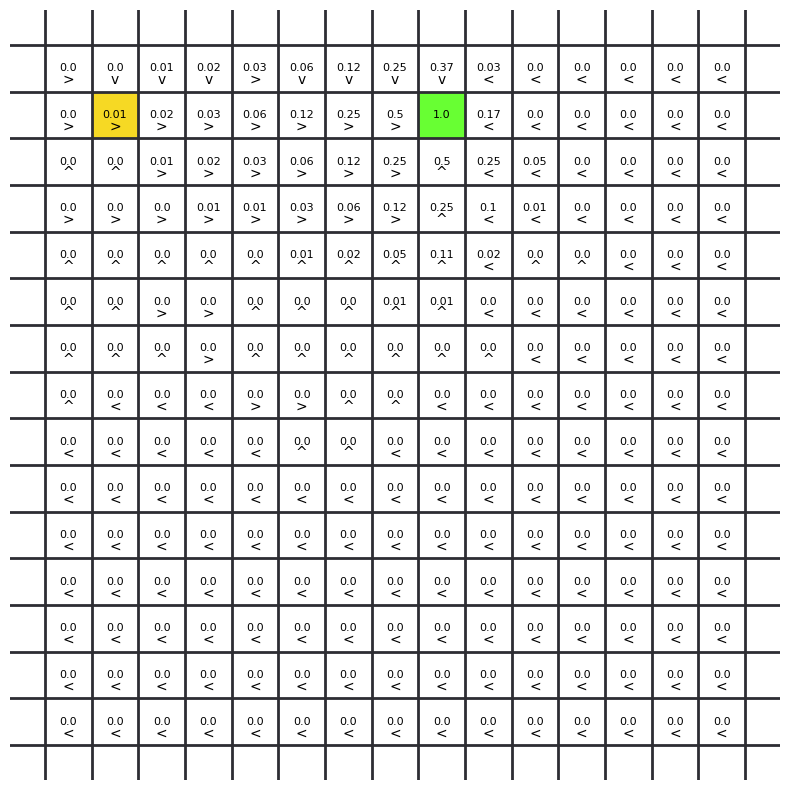

- Gráfica de convergencia de los q-valores a lo largo de los episodios


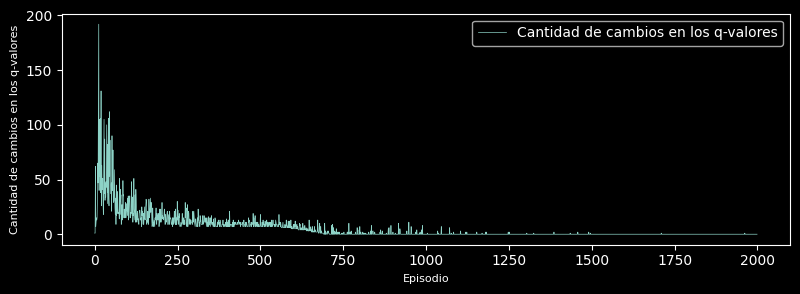


Entrenamiento para el trazo no. 3 

- Matriz de q-valores y política óptima. Tiempo de ejecución: 0.36605334281921387 segundos


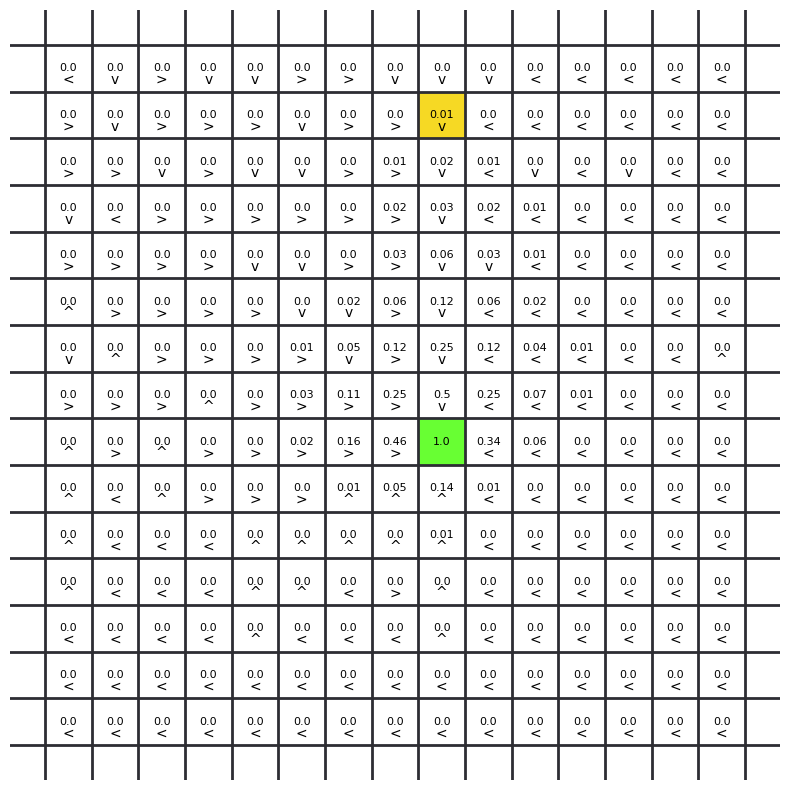

- Gráfica de convergencia de los q-valores a lo largo de los episodios


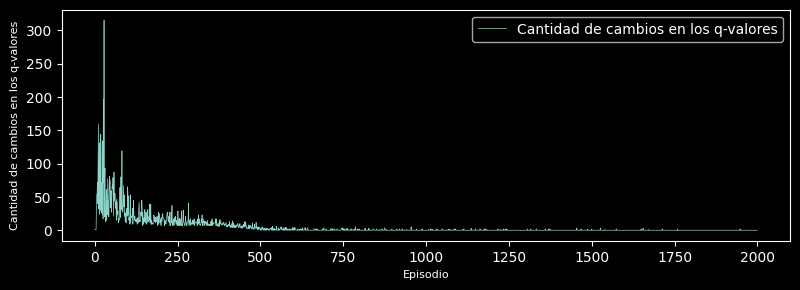


Entrenamiento para el trazo no. 4 

- Matriz de q-valores y política óptima. Tiempo de ejecución: 0.1681060791015625 segundos


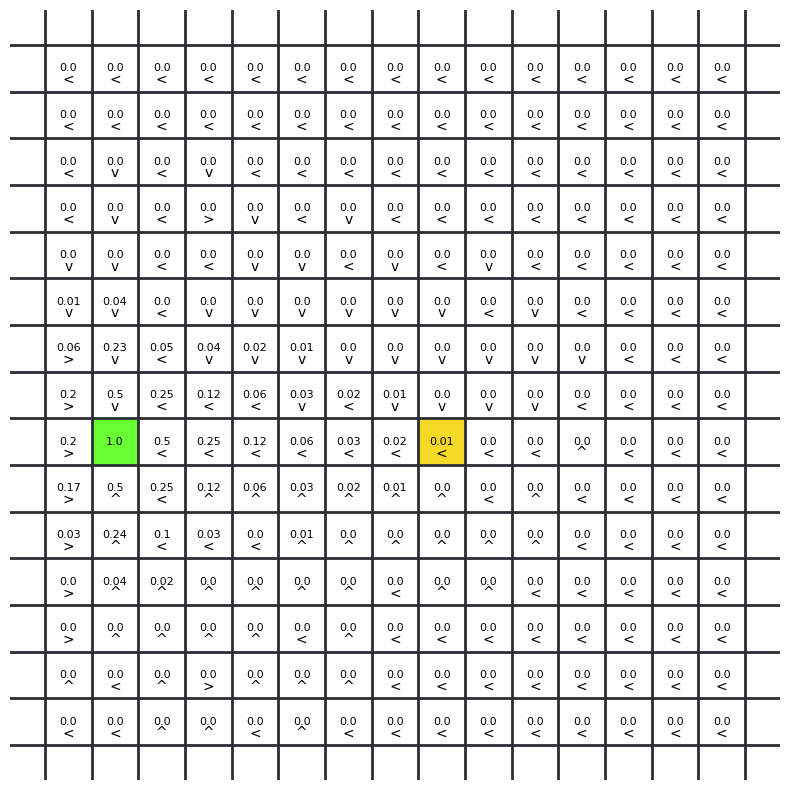

- Gráfica de convergencia de los q-valores a lo largo de los episodios


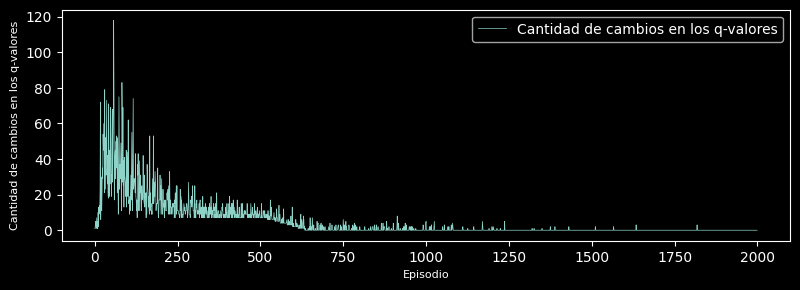


Entrenamiento para el trazo no. 5 

- Matriz de q-valores y política óptima. Tiempo de ejecución: 0.17022013664245605 segundos


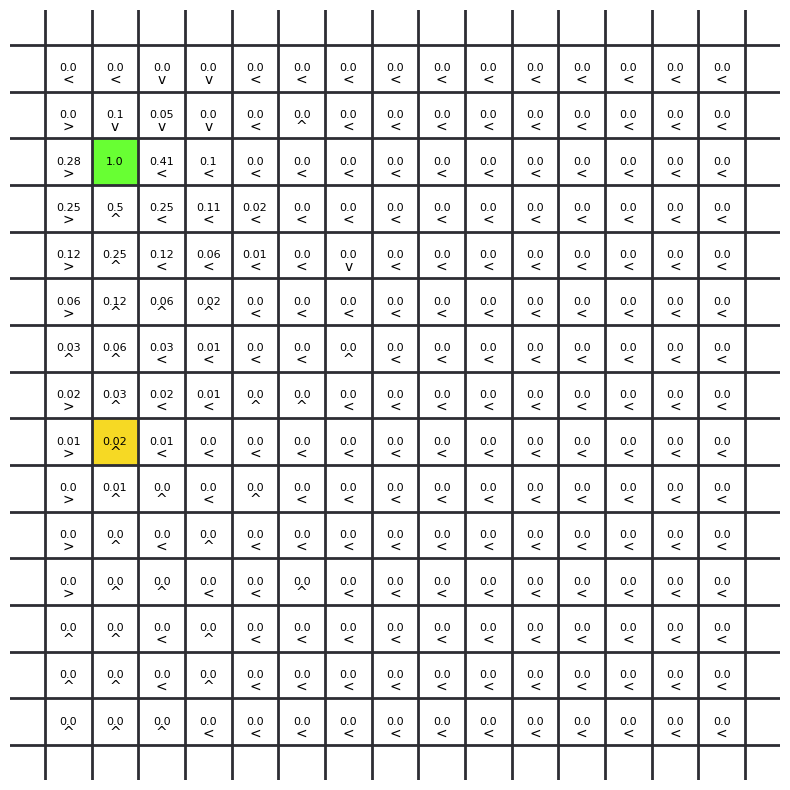

- Gráfica de convergencia de los q-valores a lo largo de los episodios


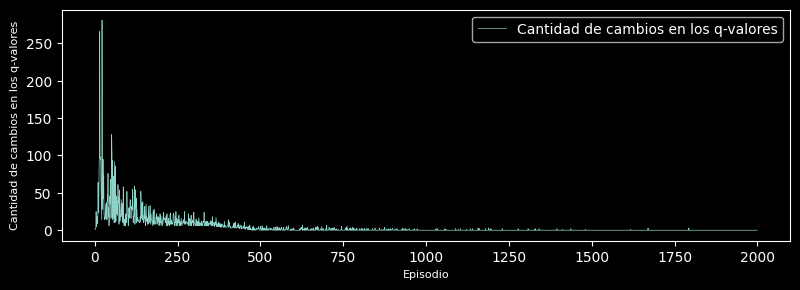


Entrenamiento para el trazo no. 6 

- Matriz de q-valores y política óptima. Tiempo de ejecución: 0.22737812995910645 segundos


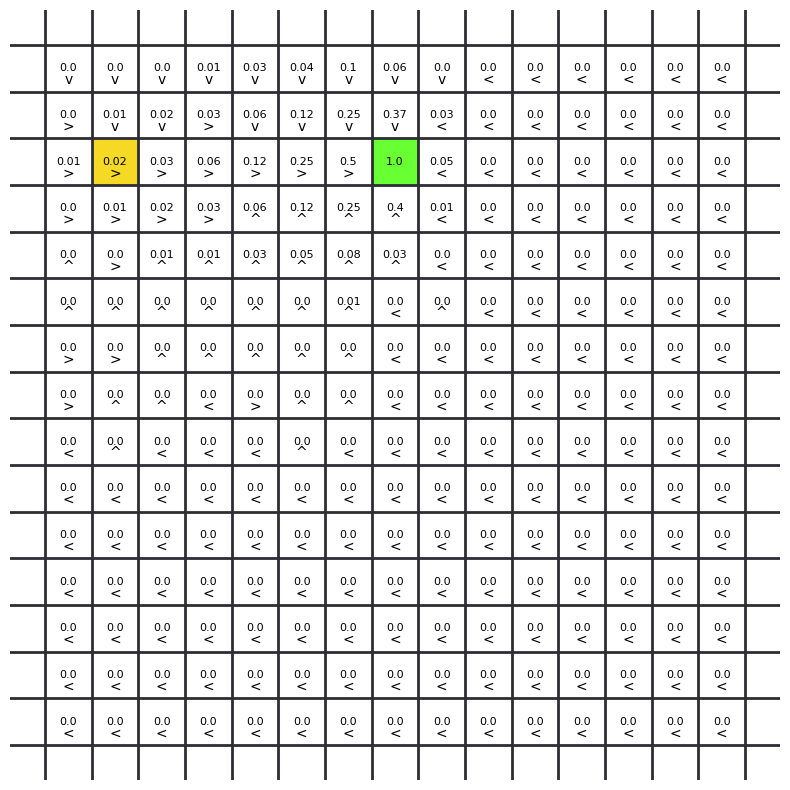

- Gráfica de convergencia de los q-valores a lo largo de los episodios


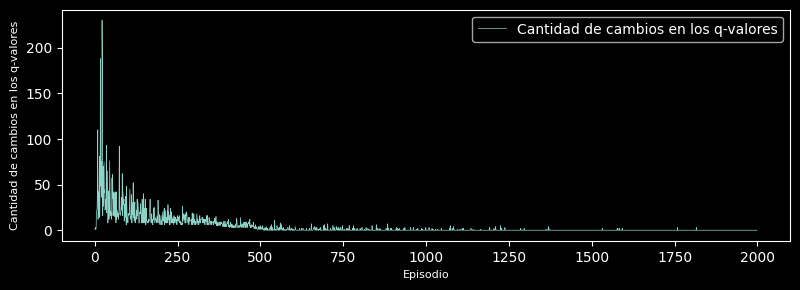


Entrenamiento para el trazo no. 7 

- Matriz de q-valores y política óptima. Tiempo de ejecución: 0.16874194145202637 segundos


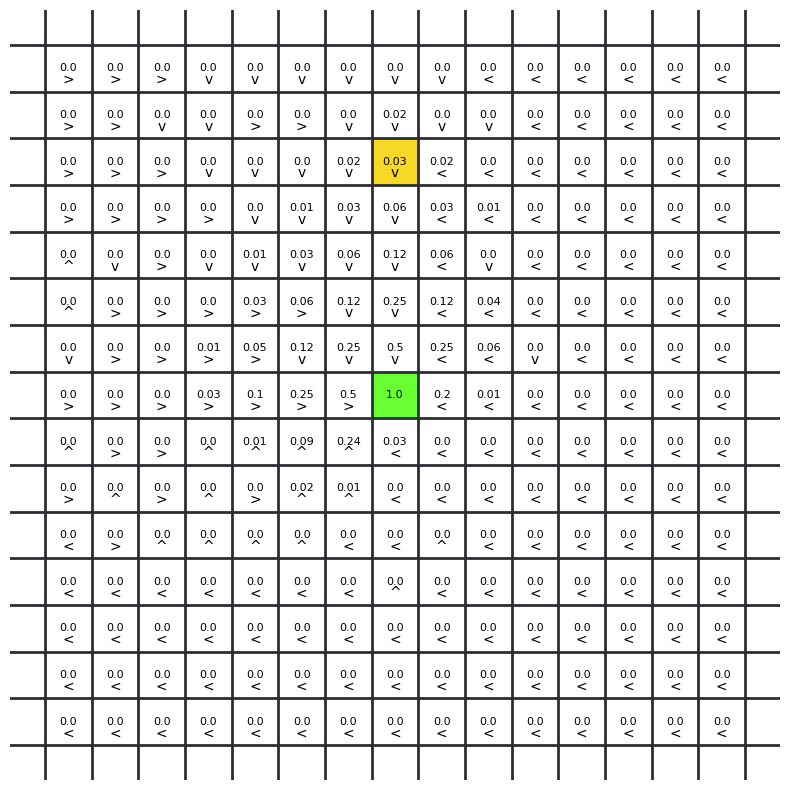

- Gráfica de convergencia de los q-valores a lo largo de los episodios


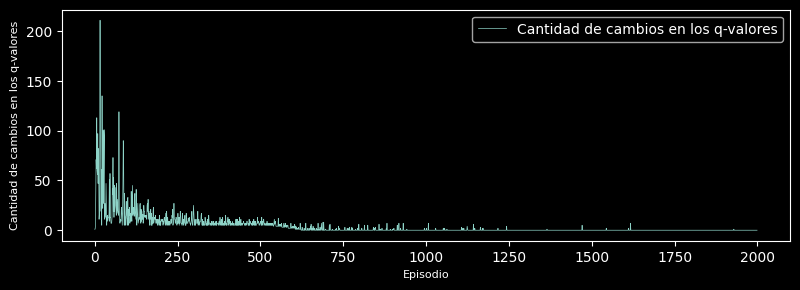


Entrenamiento para el trazo no. 8 

- Matriz de q-valores y política óptima. Tiempo de ejecución: 0.12097311019897461 segundos


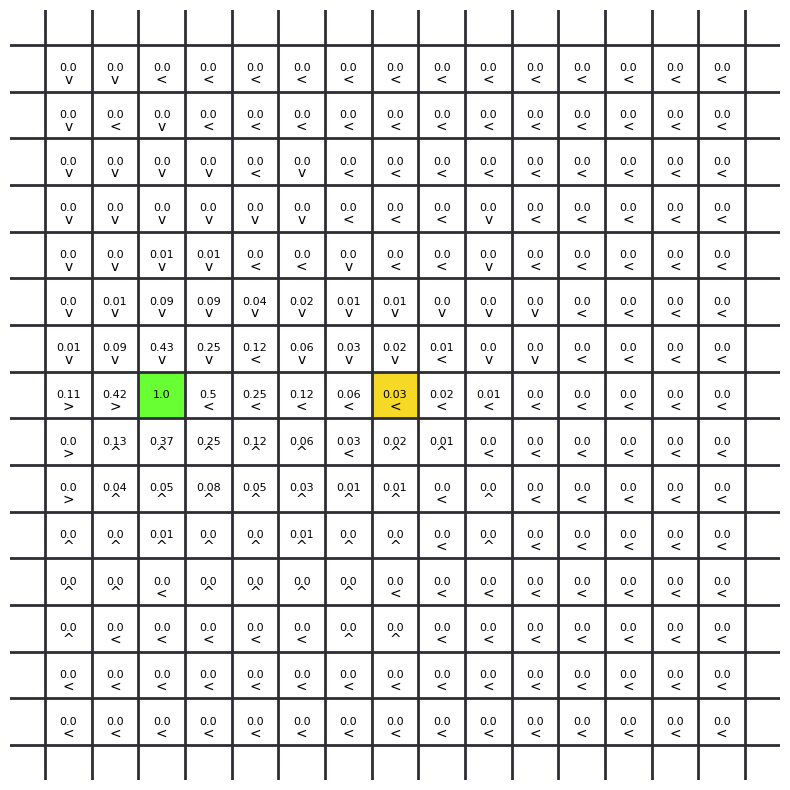

- Gráfica de convergencia de los q-valores a lo largo de los episodios


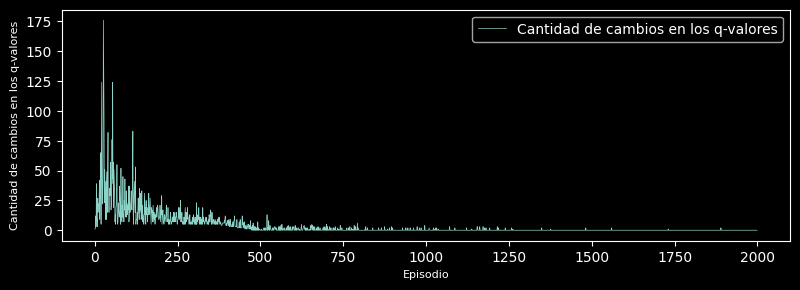


Entrenamiento para el trazo no. 9 

- Matriz de q-valores y política óptima. Tiempo de ejecución: 0.10164237022399902 segundos


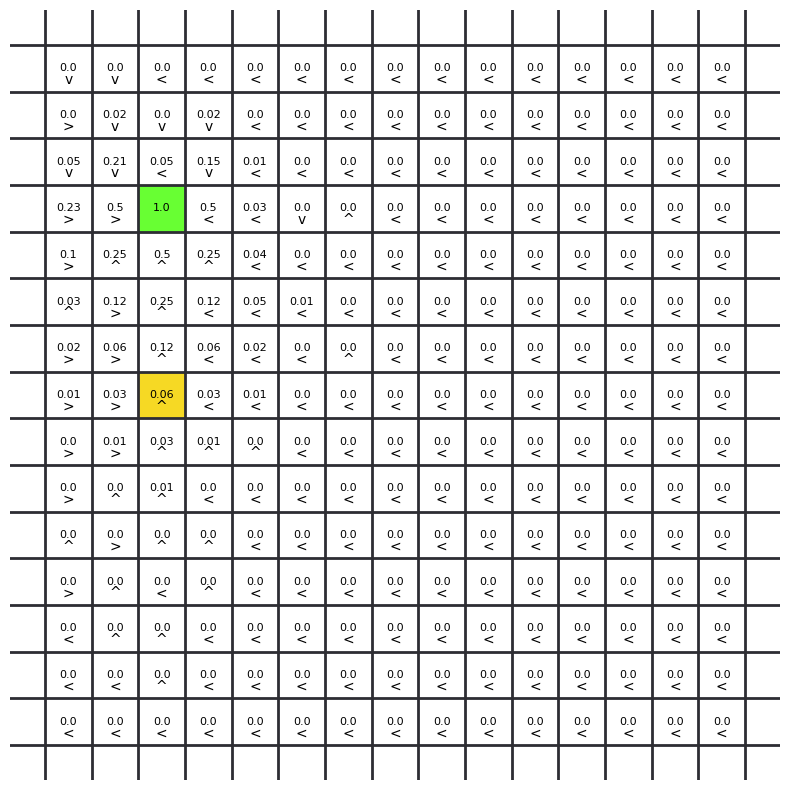

- Gráfica de convergencia de los q-valores a lo largo de los episodios


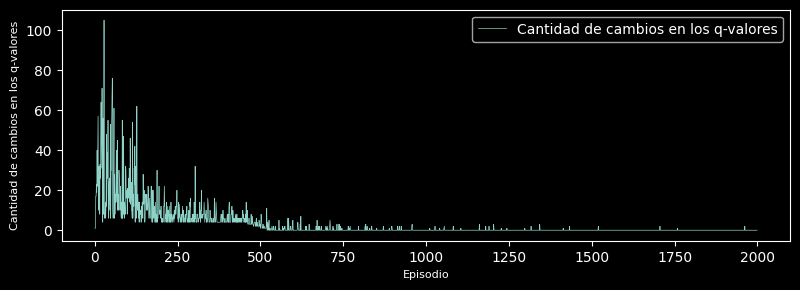


Entrenamiento para el trazo no. 10 

- Matriz de q-valores y política óptima. Tiempo de ejecución: 0.20364904403686523 segundos


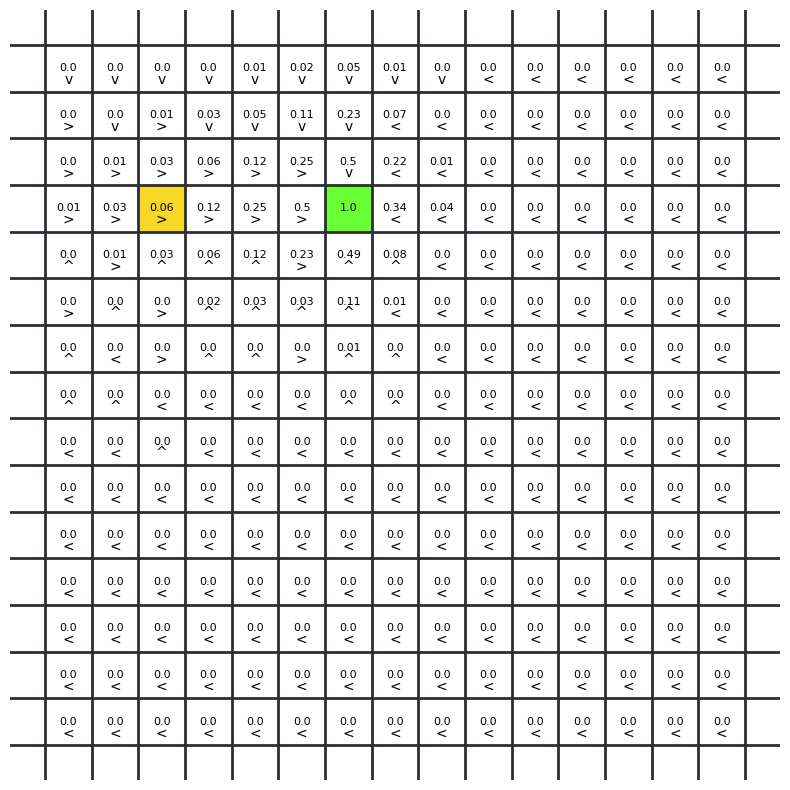

- Gráfica de convergencia de los q-valores a lo largo de los episodios


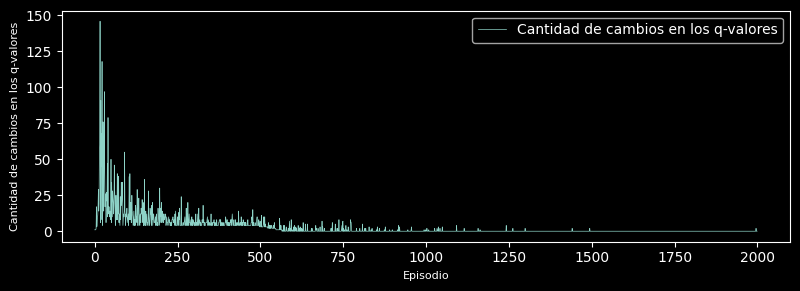


Entrenamiento para el trazo no. 11 

- Matriz de q-valores y política óptima. Tiempo de ejecución: 0.1463329792022705 segundos


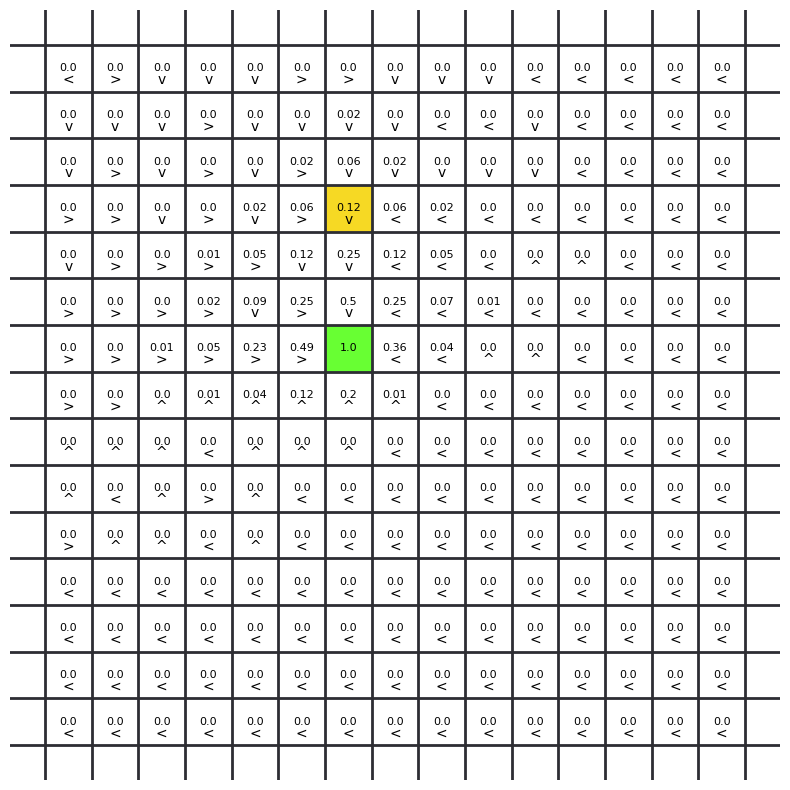

- Gráfica de convergencia de los q-valores a lo largo de los episodios


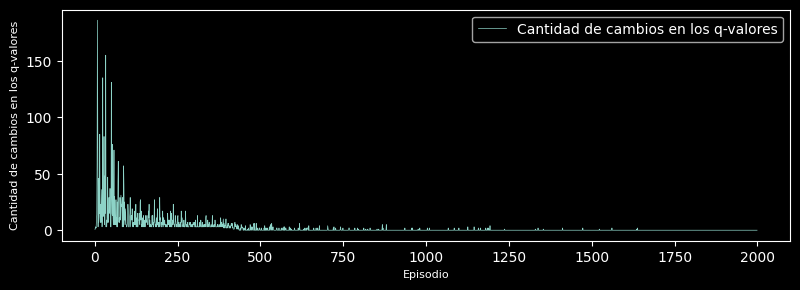


Entrenamiento para el trazo no. 12 

- Matriz de q-valores y política óptima. Tiempo de ejecución: 0.09732580184936523 segundos


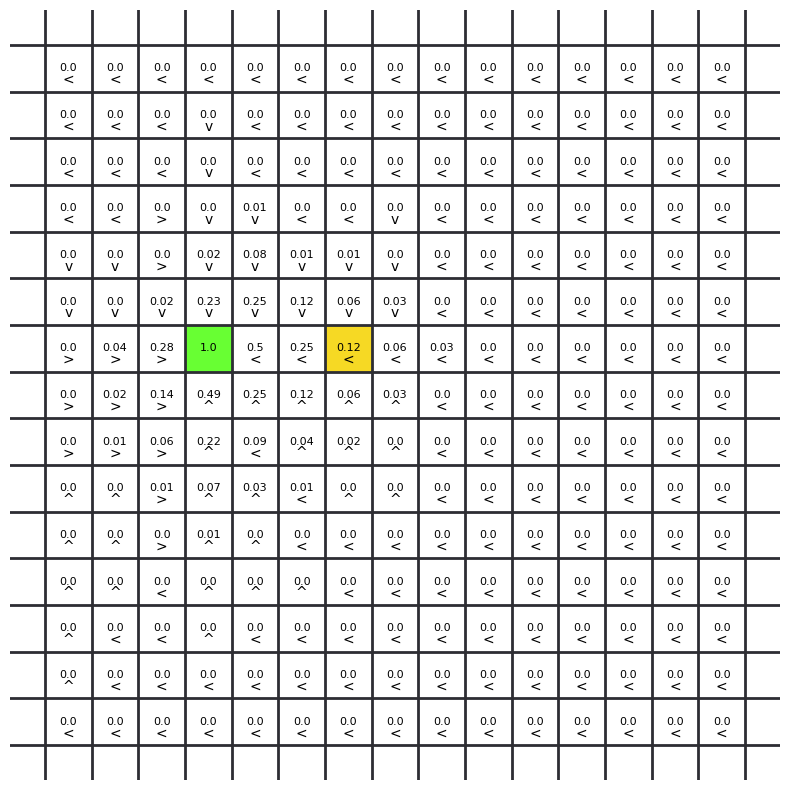

- Gráfica de convergencia de los q-valores a lo largo de los episodios


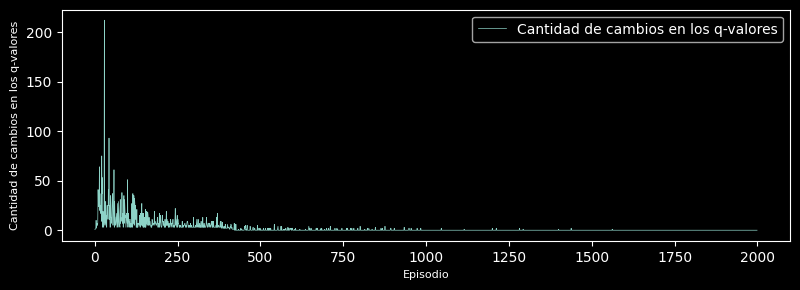


Entrenamiento para el trazo no. 13 

- Matriz de q-valores y política óptima. Tiempo de ejecución: 0.06417012214660645 segundos


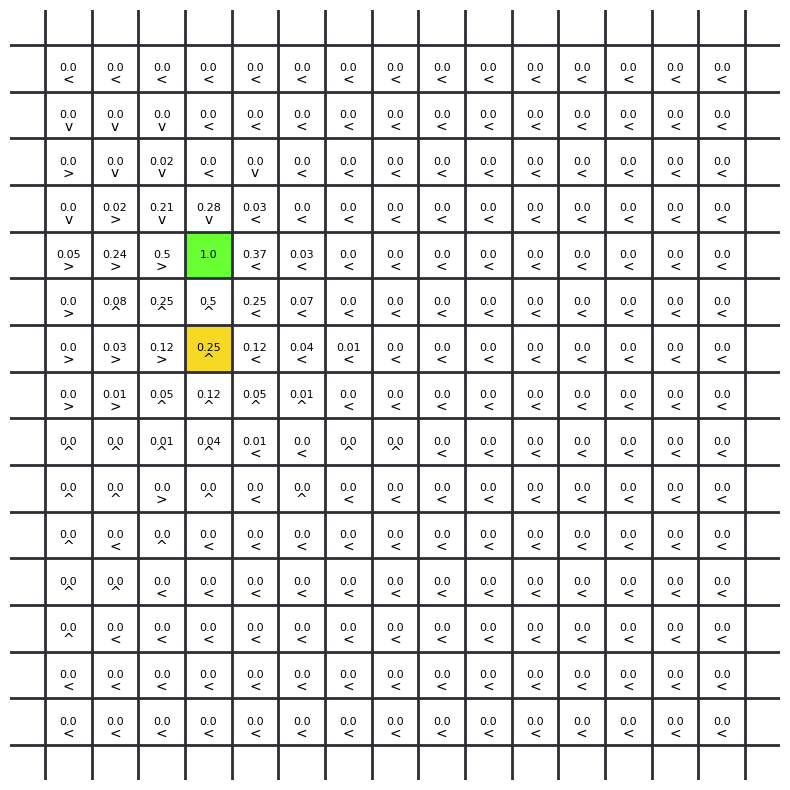

- Gráfica de convergencia de los q-valores a lo largo de los episodios


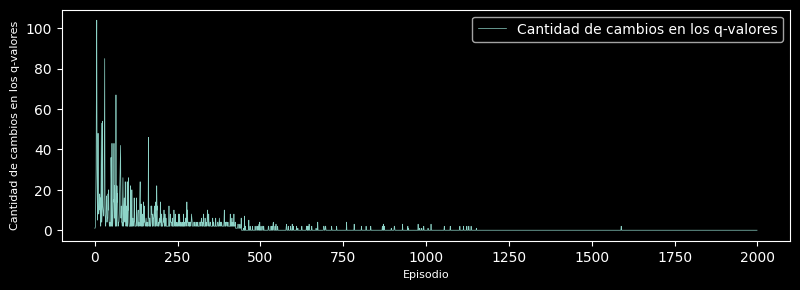

** Duracion total del entrenamiento: 6.07011604309082 segundos


In [3]:
rewards_system = Rewards().snail(size=Size.L)
snail_agents = train(rewards_system)

### **Fase de dibujo**

A continuación presentamos el código correspondiente a la fase de dibujo de Logo.

#### **Entrenamiento para dibujar un cuadrado**

Ahora que Logo está entrenado para dibujar un cuadrado, podemos usar la matriz de q-valores y su política correspondiente para guiar a Logo durante su dibujo. El código para ello se encuentra a continuación.

In [4]:
logo = Logo(step_size=15, pencolor='yellow')
logo.go_to((-5, -10))

initial_trace = True
for agent in square_agents:
    if initial_trace:
        logo._turtle.penup()
    else:
        logo._turtle.pendown()
    logo.draw(agent=agent)
    initial_trace = False

2024-05-27 22:59:54.879 Python[53133:28473989] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


Inicio un trazo en el estado: (0, 0)
Inicio un trazo en el estado: (3, 3)
Inicio un trazo en el estado: (3, 7)
Inicio un trazo en el estado: (7, 7)
Inicio un trazo en el estado: (7, 3)


#### **Entrenamiento para dibujar un caracol cuadrado**

Ahora que Logo está entrenado para dibujar un caracol cuadrado, podemos usar la matriz de q-valores y su política correspondiente para guiar a Logo durante su dibujo. El código para ello se encuentra a continuación.

In [5]:
logo = Logo(step_size=15, pencolor='blue')
logo.go_to((-5, 0))

initial_trace = True
for agent in snail_agents:
    if initial_trace:
        logo._turtle.penup()
    else:
        logo._turtle.pendown()
    logo.draw(agent=agent)
    initial_trace = False

Inicio un trazo en el estado: (0, 0)
Inicio un trazo en el estado: (1, 1)
Inicio un trazo en el estado: (1, 8)
Inicio un trazo en el estado: (8, 8)
Inicio un trazo en el estado: (8, 1)
Inicio un trazo en el estado: (2, 1)
Inicio un trazo en el estado: (2, 7)
Inicio un trazo en el estado: (7, 7)
Inicio un trazo en el estado: (7, 2)
Inicio un trazo en el estado: (3, 2)
Inicio un trazo en el estado: (3, 6)
Inicio un trazo en el estado: (6, 6)
Inicio un trazo en el estado: (6, 3)


### **Resultado**

El resultado de la ejecución del presente notebook se ilustra en la siguiente figura: 

<br>
<center>
    <img src="https://raw.githubusercontent.com/Sulfur0/turtle-drawing/master/entregable/result.png" width="600">
</center>
<center>
Figura 2. Resultado de la ejecución.
</center>